# Using Machine Learning to Forecast Air Quality in Beijing

## 4 - Machine Learning

### Import Python Packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV, RidgeCV


from sklearn import linear_model

from pylab import rcParams
rcParams['figure.figsize'] = 20, 14
plt.style.use('fivethirtyeight')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


### Load cleaned data set

In [2]:
df = pd.read_csv('data/df_with_lags_and_horizons.csv', index_col=0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10178 entries, 0 to 6
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   horizon       10178 non-null  int64  
 1   date_origin   10178 non-null  object 
 2   date_target   10178 non-null  object 
 3   target        10178 non-null  float64
 4   pred_stl      2506 non-null   float64
 5   pred_arima    2506 non-null   float64
 6   stl_lag_1     10178 non-null  float64
 7   stl_lag_2     10178 non-null  float64
 8   stl_lag_3     10178 non-null  float64
 9   stl_lag_4     10178 non-null  float64
 10  stl_lag_5     10178 non-null  float64
 11  stl_lag_6     10178 non-null  float64
 12  stl_lag_7     10178 non-null  float64
 13  stl_lag_8     10178 non-null  float64
 14  stl_lag_9     10178 non-null  float64
 15  stl_lag_10    10178 non-null  float64
 16  stl_lag_11    10178 non-null  float64
 17  stl_lag_12    10178 non-null  float64
 18  stl_lag_13    10178 non-null  

,horizon,date_origin,date_target,target,pred_stl,pred_arima,stl_lag_1,stl_lag_2,stl_lag_3,stl_lag_4,...,arima_lag_6,arima_lag_7,arima_lag_8,arima_lag_9,arima_lag_10,arima_lag_11,arima_lag_12,arima_lag_13,stl_lag_14,arima_lag_14
0,1,2011-12-31,2012-01-01,72.250000,NaN,NaN,54.625000,30.416667,20.854167,84.375000,...,52.125000,107.583333,26.416667,14.500000,14.458333,156.916667,49.416667,83.708333,NaN,NaN
1,2,2011-12-31,2012-01-02,63.416667,NaN,NaN,43.333333,54.625000,30.416667,20.854167,...,62.791667,52.125000,107.583333,26.416667,14.500000,14.458333,156.916667,49.416667,NaN,NaN
0,1,2012-01-01,2012-01-02,63.416667,NaN,NaN,43.333333,54.625000,30.416667,20.854167,...,62.791667,52.125000,107.583333,26.416667,14.500000,14.458333,156.916667,49.416667,NaN,NaN
2,3,2011-12-31,2012-01-03,14.791667,NaN,NaN,85.625000,43.333333,54.625000,30.416667,...,84.375000,62.791667,52.125000,107.583333,26.416667,14.500000,14.458333,156.916667,NaN,NaN
1,2,2012-01-01,2012-01-03,14.791667,NaN,NaN,85.625000,43.333333,54.625000,30.416667,...,84.375000,62.791667,52.125000,107.583333,26.416667,14.500000,14.458333,156.916667,NaN,NaN


In [3]:
# Generating a 7 day forecast for the first week of 2014

BURN_IN = "2012-01-01"
FORECAST_START = "2015-01-01"
FORECAST_END = "2015-12-31"
FORECAST_DAYS = 7

In [4]:
timestamps = pd.date_range(start=BURN_IN, end=FORECAST_END, freq='D')

In [5]:
def split_train_test(df, target_col, date_target_col, date_origin_col, split_date, days):

    train = df[df[date_target_col] < split_date] 
    test = df[df[date_target_col] >= split_date].head(days)
    dates = test[date_target_col]
    X_train = train.drop(target_col, axis=1)
    y_train = train[target_col]
    X_test = test.drop(target_col, axis=1)
    y_test = test[target_col]
    
    return(X_train, X_test, y_train, y_test, dates)

In [6]:
def plot_feature_importance(coef, labels):

    plt.figure()

    indices = np.argsort(coef)
    plt.barh(range(len(indices)),coef[indices])
    plt.yticks(range(len(indices)), labels[indices])
    plt.xlabel("Feature Importance")

    plt.show()

In [7]:
def plot_forecast(df, col_target_date, col_y_test, col_y_pred, horizon):

    fig, ax = plt.subplots(1, 1)

    plt.plot(col_target_date, col_y_test, data=df, linewidth=1.5)
    plt.scatter(x=col_target_date, y=col_y_pred, c=horizon, data=df)
    cb = plt.colorbar()
    cb.set_label("Horizon")
    plt.ylabel("PM2.5 Concentration")
    plt.title("Comparison of Weekly Predictions Across Horizons with Actual PM2.5 Concentration Measurements");

    dates_labels = df[col_target_date].values[::28*4]

    ax.set(xticks=dates_labels, xticklabels=dates_labels);
    plt.xticks(rotation=90);

    plt.show()

In [8]:
def fit_ML(model, df, timestamps, target_col, date_target_col, date_origin_col, start_date, days, drop_cols):

    timestamps = timestamps[timestamps >= start_date]

    results = []

    for timestamp in timestamps[:-days]:

        X_train, X_test, y_train, y_test, dates = split_train_test(df=df, target_col=target_col, date_target_col=date_target_col, date_origin_col=date_origin_col, split_date=timestamp.strftime('%Y-%m-%d'), days=days)

        model.fit(X_train.drop(drop_cols, axis=1), y_train)
        y_pred = model.predict(X_test.drop(drop_cols, axis=1))
        coef = model.coef_

        df_results = pd.DataFrame({
            'target_date': dates,
            'horizon': list(range(1,days+1)),
            'y_test': y_test.values,
            'y_pred': y_pred
        })

        results.append(df_results)

    df = pd.concat(results)

    plot_feature_importance(coef=coef, labels=X_train.drop(drop_cols, axis=1).columns)

    plot_forecast(df=df, col_target_date='target_date', col_y_test='y_test', col_y_pred='y_pred', horizon='horizon')

    return df

In [9]:
def calculate_rmse(ytest, ypred):

    se = [(ytest - ypred)**2 for (ytest, ypred) in zip(ytest, ypred)]
    rmse = (sum(se) / len(se))**0.5
    
    return rmse

In [10]:
def calculate_rmse_by_horizon(df, col_horizon, ytest, ypred):

    horizons = list(set(df[col_horizon]))
    rmses = []

    for horizon in horizons:
        df_horizon = df[df[col_horizon] == horizon]
        rmses.append(calculate_rmse(df_horizon[ytest], df_horizon[ypred]))

    df_rmse = pd.DataFrame({
        'horizon': horizons,
        'rmse': rmses
    })
    
    return df_rmse

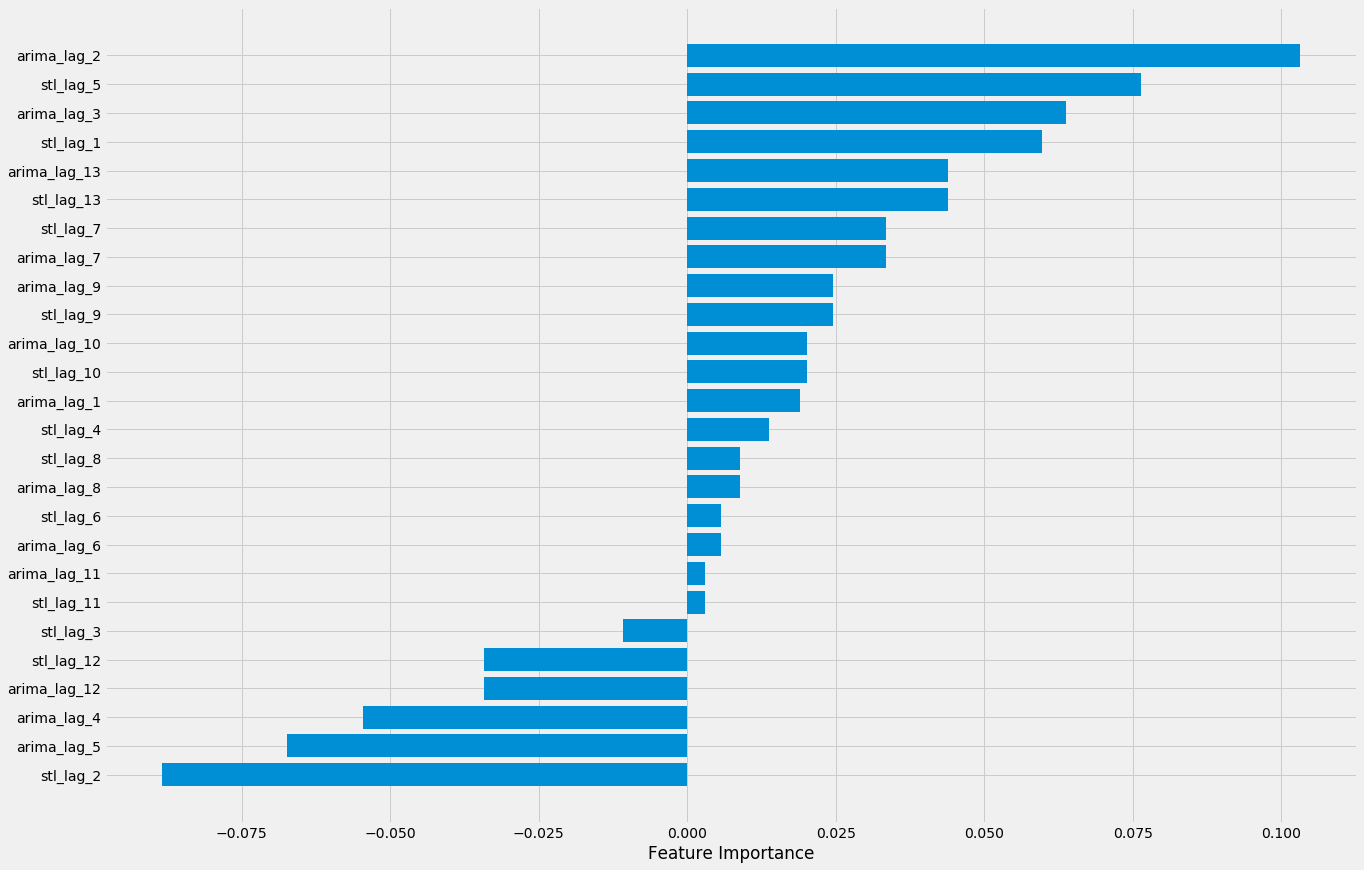

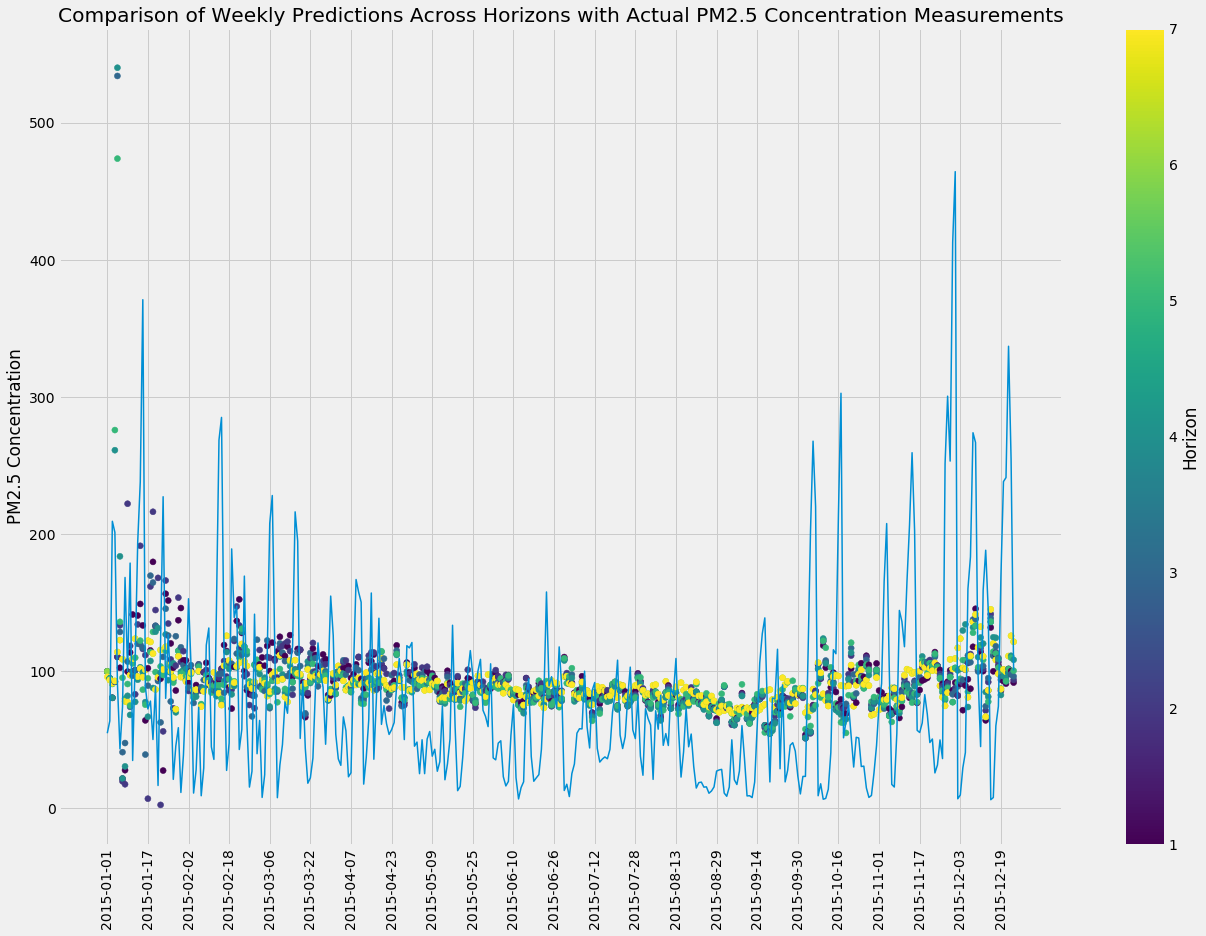

In [11]:
RidgeCV_results = fit_ML(model=linear_model.RidgeCV(), df=df, timestamps=timestamps, target_col='target', date_target_col='date_target', date_origin_col='date_origin', start_date=FORECAST_START, days=7, drop_cols=['horizon', 'date_origin', 'date_target', 'stl_lag_14', 'arima_lag_14', 'pred_stl', 'pred_arima'])

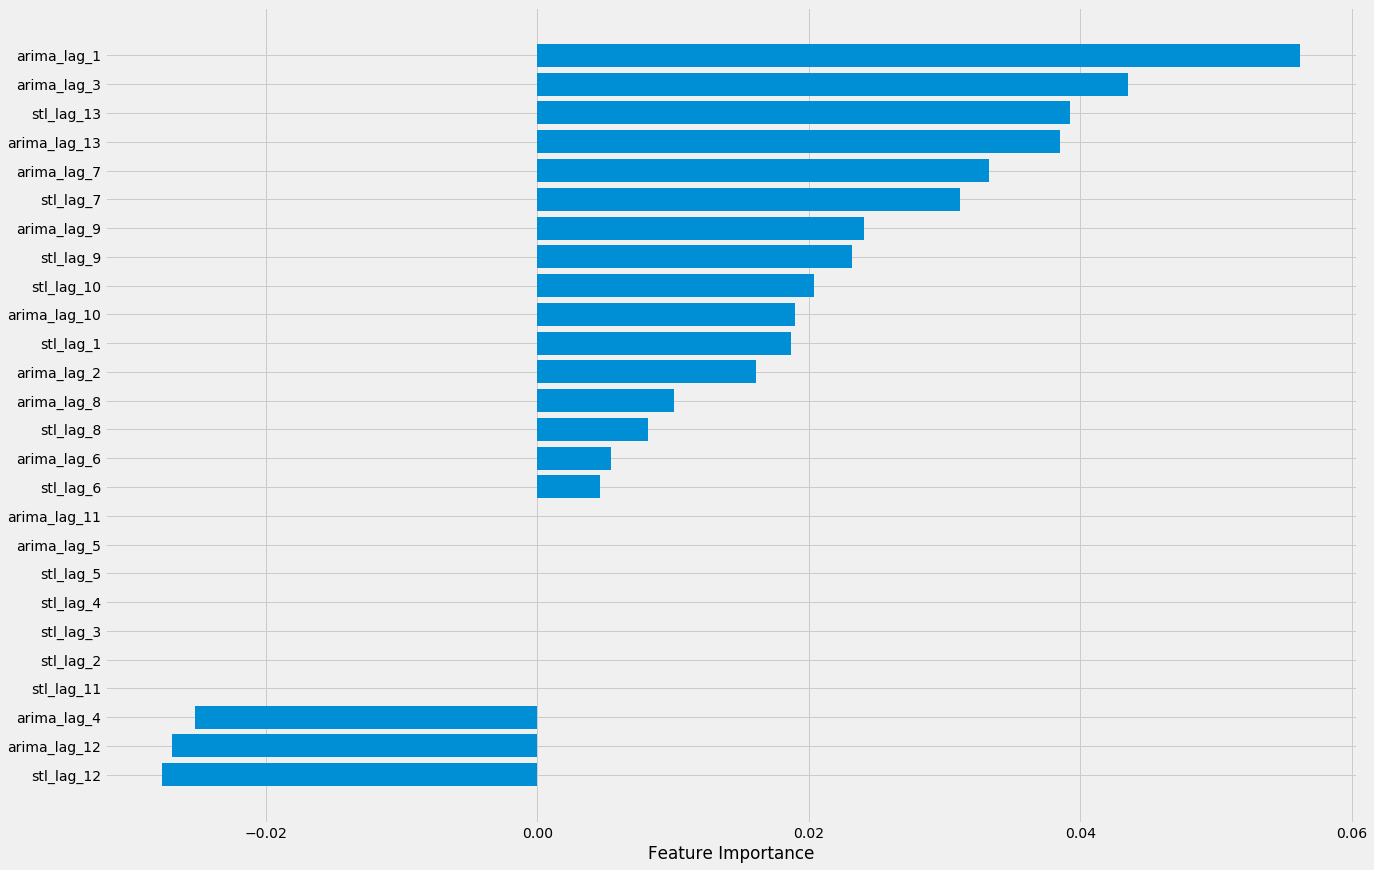

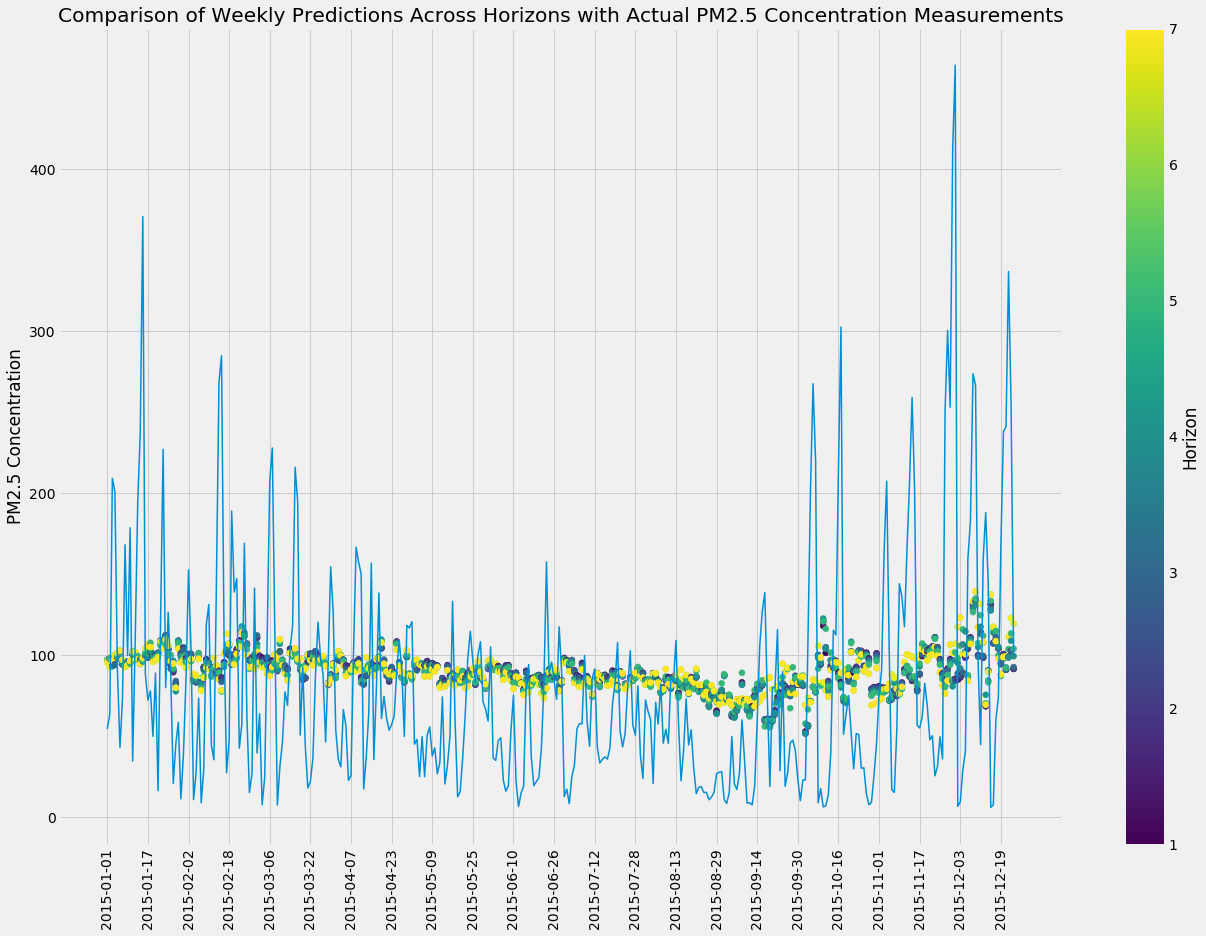

In [12]:
ElasticNetCV_results = fit_ML(model=linear_model.ElasticNetCV(), df=df, timestamps=timestamps, target_col='target', date_target_col='date_target', date_origin_col='date_origin', start_date=FORECAST_START, days=7, drop_cols=['horizon', 'date_origin', 'date_target', 'stl_lag_14', 'arima_lag_14', 'pred_stl', 'pred_arima'])

In [13]:
ElasticNetCV_results

,target_date,horizon,y_test,y_pred
6,2015-01-01,1,54.583333,97.211060
5,2015-01-01,2,54.583333,97.211060
4,2015-01-01,3,54.583333,97.211060
3,2015-01-01,4,54.583333,97.211060
2,2015-01-01,5,54.583333,97.211060
...,...,...,...,...
4,2015-12-24,3,100.416667,92.725977
3,2015-12-24,4,100.416667,99.497360
2,2015-12-24,5,100.416667,104.061993
1,2015-12-24,6,100.416667,119.558782


In [14]:
RidgeCV_results

,target_date,horizon,y_test,y_pred
6,2015-01-01,1,54.583333,99.653381
5,2015-01-01,2,54.583333,99.653381
4,2015-01-01,3,54.583333,99.653381
3,2015-01-01,4,54.583333,99.653381
2,2015-01-01,5,54.583333,99.653381
...,...,...,...,...
4,2015-12-24,3,100.416667,96.108022
3,2015-12-24,4,100.416667,108.182899
2,2015-12-24,5,100.416667,100.223195
1,2015-12-24,6,100.416667,121.336097


### Compare ARIMA and STL against ElasticNetCV and RidgeCV Predictions

In [15]:
df_ElasticNetCV_rmse = calculate_rmse_by_horizon(df=ElasticNetCV_results, col_horizon="horizon", ytest="y_test", ypred="y_pred")

In [16]:
df_RidgeCV_rmse = calculate_rmse_by_horizon(df=RidgeCV_results, col_horizon="horizon", ytest="y_test", ypred="y_pred")

In [17]:
df_arima_rmse = calculate_rmse_by_horizon(df=df[~df.pred_arima.isnull()], col_horizon="horizon", ytest="target", ypred="pred_arima")

In [18]:
df_stl_rmse = calculate_rmse_by_horizon(df=df[~df.pred_stl.isnull()], col_horizon="horizon", ytest="target", ypred="pred_stl")

Text(0.5, 1.0, 'Comparison of ARIMA, STL, ElasticNetCV, and RidgeCV RMSE')

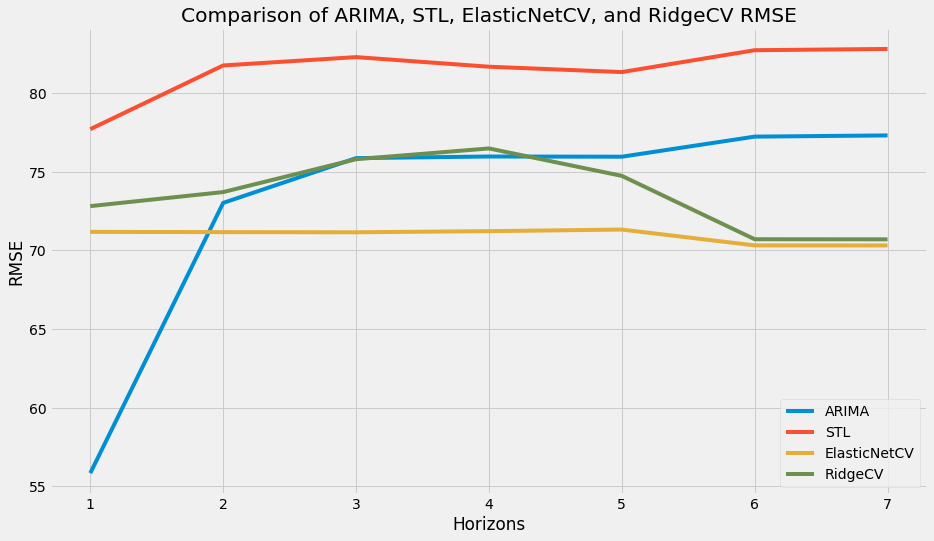

In [19]:
plt.figure(figsize=(14,8))
plt.plot(df_arima_rmse.horizon, df_arima_rmse.rmse)
plt.plot(df_stl_rmse.horizon, df_stl_rmse.rmse)
plt.plot(df_ElasticNetCV_rmse.horizon, df_ElasticNetCV_rmse.rmse)
plt.plot(df_RidgeCV_rmse.horizon, df_RidgeCV_rmse.rmse)
plt.legend(['ARIMA', 'STL', 'ElasticNetCV', 'RidgeCV'])
plt.xlabel('Horizons')
plt.ylabel('RMSE')
plt.title('Comparison of ARIMA, STL, ElasticNetCV, and RidgeCV RMSE')